In [19]:
import os
import timeit
import pandas as pd
from kernel import Kernel, Checker

In [141]:
def get_compilation_order(inc_dir):
    config_order_list = []
    with open("{}/chain".format(inc_dir)) as f:
        config_order_list = list(map(lambda x: x.strip('\n'), f.readlines()))
    return config_order_list
        
def retrieve_tmstp(inc_dir, scratch_dir):
    src = next(filter(lambda x: x.startswith("linux"), os.listdir(scratch_dir)))
    config_order = get_compilation_order(inc_dir)
    tmstp_files = ["{}/{}/dir.tmstp".format(inc_dir, cfg) for cfg in [src] + get_compilation_order(inc_dir)[1:]]
    return build_df(tmstp_files, config_order)

def parse_tmstp(tmstp_file):
    res = dict()
    with open(tmstp_file, 'r') as file:
        i = None
        for line in file:
            l = line.split(" ")
#             /!\ Linux dir should be
            if i is None:
                for j, s in enumerate(l[1].split('/')):
                    if "linux" in s:
                        i = j
            timestamp, name = l[0].strip(), "/".join(l[1].split("/")[i:]).strip('\n').strip('/')
            res[name] = timestamp
    for x in ["x64.config", "dir.tmstp", "builtins.size", "bloatto"]:
        if x in res:
            del res[x]
    return res

In [140]:
#define
NOT_EXISTING = -2
REMOVED = -1
NOT_MODIFIED = 0
MODIFIED = 1
NEW = 2

def build_df(list_files, config_order_list):
    data = [parse_tmstp(k) for k in list_files]
    state = data[0].copy()
    res = dict()
    for i, t_file in enumerate(data):
        for f in t_file:
            if f in res:
                if state[f] == t_file[f]:
                    res[f].append(NOT_MODIFIED)
                else:
                    state[f] = t_file[f]
                    res[f].append(MODIFIED)
            else:
                state[f] = t_file[f]
                res[f] = [NOT_EXISTING for j in range(i)]
                res[f].append(NEW)
        for f in res:
            lon = len(res[f])
            ri = i + 1
            if lon < ri:
                res[f].extend([REMOVED for j in range(ri-lon)])
    df = pd.DataFrame.from_dict(res)
    df.index = config_order_list
    df.index.rename("Configuration", inplace=True)
    return df


def get_delta(df):
    df_len = len(df)
    res = {i: {"REMOVED": [], "NEW": [], "NOT_MODIFIED": [], "MODIFIED": []} for i in range(df_len)}
    for i in range(df_len):
        for fi in df:
            val = df[fi][i]
            if val == REMOVED:
                res[i]["REMOVED"].append(fi)
            elif val == NOT_MODIFIED:
                res[i]["NOT_MODIFIED"].append(fi)
            elif val == MODIFIED:
                res[i]["MODIFIED"].append(fi)
            elif val == NEW:
                res[i]["NEW"].append(fi)
    return res

def delta_info_to_df(ddict):
    ddic_len = len(ddict)
    res = {"REMOVED": [], "NEW": [], "NOT_MODIFIED": [], "MODIFIED": []}
    for i in range(ddic_len):
        for j in res:
            res[j].append(len(ddict[i][j]))
    return pd.DataFrame.from_dict(res)

def draw_hist(ddf, order=None):
    ddfhist = ddf.plot.bar()
    ddfhist.set_ylabel("Nb of file")
    ddfhist.legend(["Removed", "Added", "Not modified", "Modified"],
                   loc='center left', bbox_to_anchor=(1, 0.5))        

In [153]:
def compare_timestamp(scratch, incremental, order_l):
    src = Kernel(scratch)
    Checker(src).dir_full_timestamp()
    return build_df(["{}/dir.tmstp".format(scratch),\
                     "{}/dir.tmstp".format(incremental)],
                    order_l)    

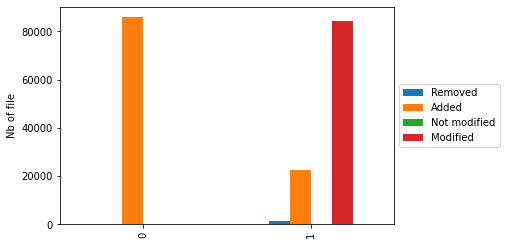

In [68]:
df = compare_timestamp("scratch/config0/linux-4.13.3/", "incremental00/linux-4.13.3/", ["config0", "config1"])
delta = get_delta(df)
delta_df = delta_info_to_df(delta)
draw_hist(delta_df)

In [144]:
def repr(df_all_list):
    delta_l = [delta_info_to_df(get_delta(df)) for df in df_all_list]
    n = len(delta_l)
    d_res = delta_l[0]
    for i in range(1, n):
        d_res = d_res.append(delta_l[i].loc[1])
    d_res.reset_index(inplace=True, drop=True)
    return d_res

## `config0` as base

### Timestamp info

In [101]:
df_all = [compare_timestamp("scratch/config0/linux-4.13.3/",\
                      "incremental{:02d}/linux-4.13.3/".format(i), ["config0", "config{}".format(i+1)])\
         for i in range(9)]

In [142]:
r = repr(df_all)
r.index = ["config{}".format(i) for i in range(10)]

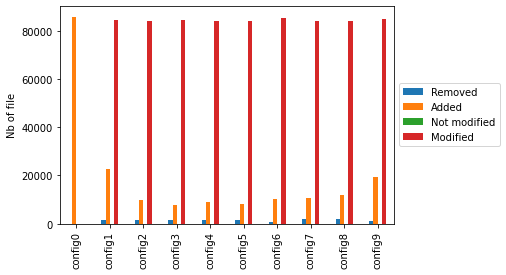

In [143]:
draw_hist(r)

### Size comparison

In [150]:
print("   scratch : incremental")
print("-----------|------------")
for i in range(1, 10):
    scratch = "scratch/config{}/linux-4.13.3/".format(i)
    incremental = "incremental{:02d}/linux-4.13.3/".format(i-1)
    print("{:10d} : {:10d}".format(os.path.getsize("{}/vmlinux".format(scratch)),
                  os.path.getsize("{}/vmlinux".format(incremental))))

   scratch : incremental
-----------|------------
  39207648 :   39207648
 677575496 :  677575304
  23852880 :   23852880
  34942360 :   34942360
  80596080 :   80596080
  31779264 :   31779264
 176648632 :  176647176
 135810816 :  135813200
  32106344 :   32106344


### Time comparison

In [152]:
print("   scratch : incremental")
print("-----------|------------")

for i in range(1, 10):
    scratch = "scratch/config{}/linux-4.13.3/".format(i)
    incremental = "incremental{:02d}/linux-4.13.3/".format(i-1)
    scratch_time = Kernel(scratch).get_compile_time()
    incremental_time = Kernel(incremental).get_compile_time()
    print("{:10f} : {:10f}".format(scratch_time, incremental_time))

   scratch : incremental
-----------|------------
906.898222 : 825.373373
393.055183 : 437.996005
285.545775 : 280.355418
395.568406 : 395.725054
388.075015 : 396.236164
386.858509 : 408.674155
579.900281 : 606.110502
473.996926 : 473.552351
644.459218 : 650.157507


### Bloat-o-meter

### Config0 -> Config1

In [201]:
with open("bom_res1", 'r') as f:
    print(f.read())

add/remove: 0/0 grow/shrink: 0/0 up/down: 0/0 (0)
function                                     old     new   delta
Total: Before=39590994, After=39590994, chg +0.00%



#### Config0 -> Config3

In [202]:
with open("bom_res3", 'r') as f:
    print(f.read())

add/remove: 0/0 grow/shrink: 187/179 up/down: 581/-555 (26)
function                                     old     new   delta
unpack_to_rootfs                            1028    1054     +26
setup_IO_APIC                               2956    2974     +18
copy_process.part                          10366   10382     +16
mtrr_trim_uncached_memory                   1998    2011     +13
acpi_table_parse_entries_array               906     919     +13
adpt_init                                   5624    5636     +12
__pci_mmcfg_init                             416     427     +11
radeonfb_init                                864     872      +8
init_gfs2_fs                                1593    1601      +8
efi_memblock_x86_reserve_range               634     642      +8
vsmp_init                                    432     439      +7
test_kstrtox_init                           2976    2983      +7
softirq_init                                 236     243      +7
run_timer_softirq             

In [165]:
import re

In [168]:
def bom_res_reader(bom_res):
    l = ""
    with open(bom_res, 'r') as bf:
        l = bf.readline()
    print(l)
    m = re.search(r"add/remove: (\d+)/(\d+) grow/shrink: (\d+)/(\d+) up/down: (\d+)/(\d+)", l)
    return {"add": m.group(1),
           "remove": m.group(2),
           "grow": m.group(3),
           "shrink": m.group(4),
           "up": m.group(5),
           "down": m.group(6)}

In [188]:
l = "add/remove: 0/0 grow/shrink: 187/179 up/down: 581/-555 (26)"

In [195]:
m = re.search(r"add/remove: (\d+)/(\d+) grow/shrink: (\d+)/([^-\d+]) up/down: (\d+)/([-\d+])", l)